# K-Nearest Neighbour

#### Imports

In [5]:
import time

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
    recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

#### Header Information

In [6]:

# Exclusion list and column definitions
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

#### Helper Functions

In [7]:

#### Helper Functions
def define_numeric_column(data: pd.DataFrame):
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]


def print_score():
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"TUNED RANDOM FOREST")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("Random Forest Model Evaluation:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_names = np.unique(y)
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))


def check_fitting():
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:
        print("Possible Overfitting: Training accuracy is significantly higher than testing accuracy.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:
        print("Possible Underfitting: Both training and testing accuracies are low.")
    else:
        print("Good Fit: Training and testing accuracies are reasonably close.")


def preprocess_data(data: pd.DataFrame) -> tuple:
    try:
        data = data.copy()
        data['su_attempted'] = data['su_attempted'].replace({2: 0}, inplace=False)
        numeric = define_numeric_column(data)
        return data[nominal + numeric + binary], data['attack_category']
    except Exception as e:
        raise ValueError(f"Error in preprocessing: {str(e)}")


def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])

#### Model Training & Evaluation

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
df = pd.read_csv('./data/kdd_merged.csv')
X, y = preprocess_data(df)
label_encode_nominal_data(X)

# Scale numerical features (KNN is distance-based)
numeric_cols = define_numeric_column(df)
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()
knn_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on both training and testing sets
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

# Calculate accuracies and metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
print_score()
check_fitting()

TUNED RANDOM FOREST

Classification Report:
               precision    recall  f1-score   support

      benign       0.99      0.99      0.99     15411
         dos       1.00      1.00      1.00     10713
       probe       0.98      0.98      0.98      2816
         r2l       0.94      0.93      0.94       714
         u2r       0.84      0.72      0.77        50

    accuracy                           0.99     29704
   macro avg       0.95      0.92      0.94     29704
weighted avg       0.99      0.99      0.99     29704

Random Forest Model Evaluation:
Training Time: 0.2930 seconds
Training Accuracy: 0.9934
Testing Accuracy: 0.9907
Precision (Weighted): 0.9907
Recall (Weighted): 0.9907
F1-Score (Weighted): 0.9907

Confusion Matrix with Class Labels:
        benign    dos  probe  r2l  u2r
benign   15297     34     41   36    3
dos         44  10665      4    0    0
probe       40      9   2765    1    1
r2l         40      0      5  666    3
u2r         10      0      0    4   36

# ROC

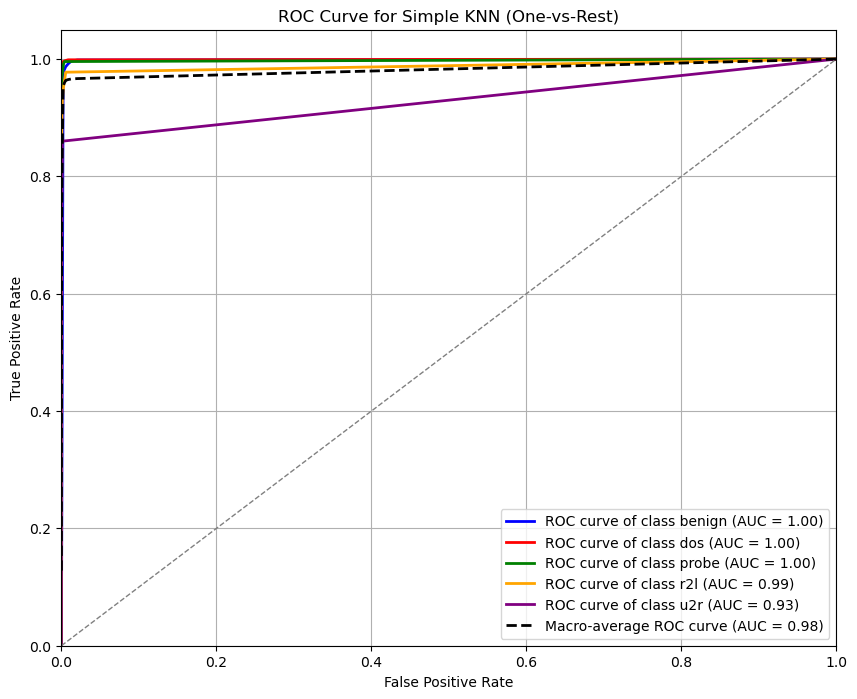

In [9]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

class_names = np.unique(y)
# --- ROC Curve Visualization ---
y_test_prob = knn_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=class_names)
n_classes = len(class_names)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], color='black', lw=2, linestyle='--',
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Simple KNN (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()